In [2]:
# WE'll first try to use neural networks to make a multiclassifier model. 
# If the accuracy is good, we keept. if not, we then predict the label first, then for label == 1, we multiclassify.

In [15]:
# Importing all the libraries I will be using 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Loading the data
# Load your cleaned dataset
df = pd.read_csv('/kaggle/input/cleaned-logged-cyber-threat-dataset/df_log_clipped.csv')

# Drop the 'label' column since we're only working on multiclass
df = df.drop(columns=['label'])

In [16]:
# Define major classes
major_classes = ['normal', 'exploits', 'fuzzers', 'generic']

# Merge into 'others' if not major
df['attack_cat'] = df['attack_cat'].apply(lambda x: x if x in major_classes else 'others')

# Now we have only 5 classes
print(df['attack_cat'].value_counts())

attack_cat
normal      1938908
exploits      27436
others        21163
fuzzers       20965
generic       18860
Name: count, dtype: int64


In [20]:
# Automatically identify categorical columns in the DataFrame
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns detected:", cat_cols)

Categorical columns detected: ['proto', 'state', 'service', 'attack_cat']


In [21]:
# Cell 5: Encode all detected categorical columns
from sklearn.preprocessing import LabelEncoder

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    encoders[col] = le
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"{col} mapping: {mapping}")

# Drop original categorical columns now that they’re encoded
df = df.drop(columns=cat_cols)

proto mapping: {'3pc': 0, 'aessp3d': 1, 'an': 2, 'any': 3, 'argus': 4, 'aris': 5, 'arp': 6, 'ax25': 7, 'bbnrcc': 8, 'bna': 9, 'brsatmon': 10, 'cbt': 11, 'cftp': 12, 'chaos': 13, 'compaqpeer': 14, 'cphb': 15, 'cpnx': 16, 'crtp': 17, 'crudp': 18, 'dcn': 19, 'ddp': 20, 'ddx': 21, 'dgp': 22, 'egp': 23, 'eigrp': 24, 'emcon': 25, 'encap': 26, 'esp': 27, 'etherip': 28, 'fc': 29, 'fire': 30, 'ggp': 31, 'gmtp': 32, 'gre': 33, 'hmp': 34, 'iatp': 35, 'ib': 36, 'icmp': 37, 'idpr': 38, 'idprcmtp': 39, 'idrp': 40, 'ifmp': 41, 'igmp': 42, 'igp': 43, 'il': 44, 'inlsp': 45, 'ip': 46, 'ipcomp': 47, 'ipcv': 48, 'ipip': 49, 'iplt': 50, 'ipnip': 51, 'ippc': 52, 'ipv6': 53, 'ipv6frag': 54, 'ipv6no': 55, 'ipv6opts': 56, 'ipv6route': 57, 'ipxnip': 58, 'irtp': 59, 'isis': 60, 'isoip': 61, 'isotp4': 62, 'kryptolan': 63, 'l2tp': 64, 'larp': 65, 'leaf1': 66, 'leaf2': 67, 'meritinp': 68, 'mfensp': 69, 'mhrp': 70, 'micp': 71, 'mobile': 72, 'mtp': 73, 'mux': 74, 'narp': 75, 'netblt': 76, 'nsfnetigp': 77, 'nvp': 78, 

In [22]:
# Cell 6: Prepare features & target, then split into train/test

# If the original 'label' column is still present, drop it
if 'label' in df.columns:
    df = df.drop(columns=['label'])

# Define feature matrix X and target vector y
X = df.drop(columns=['attack_cat_encoded'])
y = df['attack_cat_encoded']

# Inspect shapes and class balance
print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())

# Train–test split (stratified to preserve class ratios)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("\nAfter split:")
print("  X_train:", X_train.shape, "  y_train:", y_train.shape)
print("  X_test: ", X_test.shape,  "  y_test: ",  y_test.shape)

Feature matrix shape: (2027332, 41)
Target distribution:
 attack_cat_encoded
3    1938908
0      27436
4      21163
1      20965
2      18860
Name: count, dtype: int64

After split:
  X_train: (1621865, 41)   y_train: (1621865,)
  X_test:  (405467, 41)   y_test:  (405467,)


In [23]:
# Cell 7: Compute class weights & select device
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Compute class weights from the training labels
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

# Show the mapping of class → weight
print("Class → weight:", dict(zip(classes, class_weights.cpu().numpy())))

Using device: cuda
Class → weight: {0: 14.778486, 1: 19.34015, 2: 21.498741, 3: 0.20912099, 4: 19.159657}


In [24]:
# Cell 8: Create PyTorch Dataset & DataLoader with numeric + categorical inputs
import torch
from torch.utils.data import Dataset, DataLoader

# Identify categorical encoded columns (excluding the target)
cat_cols_encoded = [col for col in X_train.columns 
                    if col.endswith('_encoded') and col != 'attack_cat_encoded']
# Identify remaining numeric columns
numeric_cols = [col for col in X_train.columns if col not in cat_cols_encoded]

print("Numeric columns:", len(numeric_cols), numeric_cols[:5], "…")
print("Categorical encoded columns:", cat_cols_encoded)

class CyberDataset(Dataset):
    def __init__(self, X_df, y_series):
        # Numeric features tensor
        self.X_num = torch.tensor(X_df[numeric_cols].values, dtype=torch.float32)
        # Categorical features as individual tensors
        self.X_cat = {
            col: torch.tensor(X_df[col].values, dtype=torch.long)
            for col in cat_cols_encoded
        }
        # Labels tensor
        self.y = torch.tensor(y_series.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Unpack numeric + each categorical + label
        x_num = self.X_num[idx]
        x_proto = self.X_cat['proto_encoded'][idx]
        x_state = self.X_cat['state_encoded'][idx]
        x_service = self.X_cat['service_encoded'][idx]
        y = self.y[idx]
        return x_num, x_proto, x_state, x_service, y

# Instantiate datasets
train_dataset = CyberDataset(X_train, y_train)
test_dataset  = CyberDataset(X_test,  y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))

Numeric columns: 38 ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl'] …
Categorical encoded columns: ['proto_encoded', 'state_encoded', 'service_encoded']
Train batches: 3168 Test batches: 792


In [25]:
# Cell 9: Define FocalLoss and the embedding-based model
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # compute cross-entropy per sample
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        # convert to pt
        pt = torch.exp(-ce_loss)
        # focal modulation
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class CyberThreatClassifier(nn.Module):
    def __init__(self, num_numerical,
                 proto_vocab_size, state_vocab_size, service_vocab_size,
                 emb_dims=(4, 4, 6)):
        super(CyberThreatClassifier, self).__init__()
        e_proto, e_state, e_service = emb_dims
        # embedding layers
        self.emb_proto   = nn.Embedding(proto_vocab_size,   e_proto)
        self.emb_state   = nn.Embedding(state_vocab_size,   e_state)
        self.emb_service = nn.Embedding(service_vocab_size, e_service)
        # combined input dim
        input_dim = num_numerical + e_proto + e_state + e_service
        # fully connected layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128,       64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64,        32)
        self.out = nn.Linear(32,         5)  # 5 classes

    def forward(self, x_num, x_proto, x_state, x_service):
        p = self.emb_proto(x_proto)
        s = self.emb_state(x_state)
        svc = self.emb_service(x_service)
        # concat numeric + embeddings
        x = torch.cat([x_num, p, s, svc], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return self.out(x)

In [26]:
# Cell 10: Define Embedding + Deeper MLP Model
import torch.nn as nn
import torch.nn.functional as F

class DeepCyberThreatClassifier(nn.Module):
    def __init__(self,
                 num_numerical,
                 proto_vocab_size, state_vocab_size, service_vocab_size,
                 emb_dims=(4, 4, 6)):
        super().__init__()
        # Embedding layers
        self.emb_proto   = nn.Embedding(proto_vocab_size,   emb_dims[0])
        self.emb_state   = nn.Embedding(state_vocab_size,   emb_dims[1])
        self.emb_service = nn.Embedding(service_vocab_size, emb_dims[2])
        
        # Total input dim = numericals + all embedding dims
        total_dim = num_numerical + sum(emb_dims)
        
        # Deeper MLP
        self.net = nn.Sequential(
            nn.Linear(total_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128,  64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64,   32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32,   16),
            nn.ReLU(),
            
            nn.Linear(16,    5)    # 5 output classes
        )

    def forward(self, x_num, x_proto, x_state, x_service):
        # Look up embeddings
        p   = self.emb_proto(x_proto)
        s   = self.emb_state(x_state)
        svc = self.emb_service(x_service)
        
        # Concatenate numerical + categorical embeddings
        x = torch.cat([x_num, p, s, svc], dim=1)
        
        # Forward through MLP
        return self.net(x)

In [27]:
# Cell 11: Instantiate model, define loss & optimizer

# Instantiate the deeper MLP with embeddings
model = DeepCyberThreatClassifier(
    num_numerical=len(numeric_cols),
    proto_vocab_size=len(encoders['proto'].classes_),
    state_vocab_size=len(encoders['state'].classes_),
    service_vocab_size=len(encoders['service'].classes_)
).to(device)

# Use Focal Loss with your class weights
criterion = FocalLoss(alpha=class_weights, gamma=2.0)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

DeepCyberThreatClassifier(
  (emb_proto): Embedding(135, 4)
  (emb_state): Embedding(16, 4)
  (emb_service): Embedding(12, 6)
  (net): Sequential(
    (0): Linear(in_features=52, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=16, bias=True)
    

Epoch 01/30 — Loss: 1.0667
Epoch 02/30 — Loss: 1.0250
Epoch 03/30 — Loss: 1.0118
Epoch 04/30 — Loss: 1.0051
Epoch 05/30 — Loss: 1.0028
Epoch 06/30 — Loss: 0.9989
Epoch 07/30 — Loss: 0.9967
Epoch 08/30 — Loss: 0.9944
Epoch 09/30 — Loss: 0.9924
Epoch 10/30 — Loss: 0.9907
Epoch 11/30 — Loss: 0.9895
Epoch 12/30 — Loss: 0.9876
Epoch 13/30 — Loss: 0.9861
Epoch 14/30 — Loss: 0.9846
Epoch 15/30 — Loss: 0.9829
Epoch 16/30 — Loss: 0.9824
Epoch 17/30 — Loss: 0.9800
Epoch 18/30 — Loss: 0.9799
Epoch 19/30 — Loss: 0.9791
Epoch 20/30 — Loss: 0.9774
Epoch 21/30 — Loss: 0.9761
Epoch 22/30 — Loss: 0.9751
Epoch 23/30 — Loss: 0.9757
Epoch 24/30 — Loss: 0.9735
Epoch 25/30 — Loss: 0.9734
Epoch 26/30 — Loss: 0.9732
Epoch 27/30 — Loss: 0.9725
Epoch 28/30 — Loss: 0.9717
Epoch 29/30 — Loss: 0.9711
Epoch 30/30 — Loss: 0.9707

=== Classification Report ===
              precision    recall  f1-score   support

    exploits       0.04      0.90      0.08      5487
     fuzzers       0.21      0.09      0.13      4

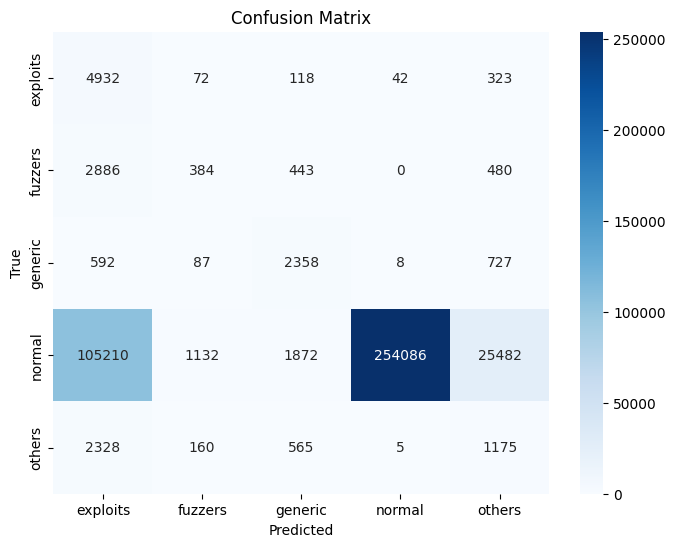

In [28]:
# Cell 12: Training loop + immediate evaluation
num_epochs = 30

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for x_num, x_proto, x_state, x_service, labels in train_loader:
        x_num = x_num.to(device)
        x_proto = x_proto.to(device)
        x_state = x_state.to(device)
        x_service = x_service.to(device)
        labels = labels.to(device)

        # forward + loss
        outputs = model(x_num, x_proto, x_state, x_service)
        loss = criterion(outputs, labels)

        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch:02d}/{num_epochs} — Loss: {avg_loss:.4f}")

# After training, immediately evaluate:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x_num, x_proto, x_state, x_service, labels in test_loader:
        x_num = x_num.to(device)
        x_proto = x_proto.to(device)
        x_state = x_state.to(device)
        x_service = x_service.to(device)
        labels = labels.to(device)

        outputs = model(x_num, x_proto, x_state, x_service)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()